# How does Twitter Discuss Trans People?

Introduction section

Mention algorithms, technologies, etc. We will use LDA, w2v, etc.

## Data engineering

### Scraping

This data was collected using [Twarc](https://github.com/DocNow/twarc), a command-line tool for scraping data from Twitter. We used the following bash command:

```sh
twarc --recursive search '"transgender" OR "trans person" OR "trans people" OR "transmasc" OR "transfem" OR "trans man" OR "trans woman" OR "trans boy" OR "trans girl" OR "trans men" OR "trans women" OR "enby" OR "non binary"' | tee /dev/tty | gzip --stdout > $OUTFILE
```

This command does the following things:
1. Searches for every tweet from the past week that contains the specified terms.
2. Prints it to console for easier reading.
3. Gzips the data to reduce disk space
4. Saves the data to wherever `$OUTFILE` is.

### Combining the data

Now, we will combine all the data into a single dataframe. 

In [1]:
import pickle
import sys
import os

import gzip
from datetime import datetime

import jsonlines
import pandas as pd

def autopickle(path):
    """
    This is a decorator to aid in pickling important things.
    
    If a file exists at the path, then this will load that gzipped pickle object.
    Otherwise, it will run the function, pickle and gzip the result, and return the function.
    """
    def decorator(func):
        if os.path.exists(path):
            with gzip.open(path, 'rb') as file:
                model = pickle.load(file)
        else:
            model = func()
            with gzip.open(path, 'wb') as file:
                pickle.dump(model, file)
        return model
    return decorator


def parse_twitter_datetime(dt: str):
    return datetime.strptime(dt, '%a %b %d %H:%M:%S +0000 %Y')


def read_jsonl_gz(path):
    with jsonlines.Reader(gzip.open(path)) as reader:
        raw_politician_tweets = list(reader)

    tweet_df = pd.DataFrame(data={
        'tweet': [t['full_text'] for t in raw_politician_tweets],
        'author': [t['user']['screen_name'] for t in raw_politician_tweets],
        'date': [parse_twitter_datetime(t['created_at']) for t in raw_politician_tweets],
        'id': [t['id'] for t in raw_politician_tweets]
    })
    tweet_df.set_index('id')

    return tweet_df

In [2]:
@autopickle('../data/joined_tweets.pickle.gz')
def tweet_df():
    INPUTS = [
        '../data/transgender/2021-05-06_2021-05-13.jsonl.gz',
        '../data/transgender/2021-05-12_2021-05-20.jsonl.gz',
    ]
    # Read all the JSONL dataframes
    dfs = [read_jsonl_gz(path) for path in INPUTS]
    
    # Concatenate the dataframes
    df = pd.concat(dfs)
    
    # Drop duplicate tweets
    df.drop_duplicates('id', inplace=True)
    return df

tweet_df

,tweet,author,date,id
0,It really is about who has autonomy over their...,POLITICOLive,2021-05-13 17:30:52,1392895129304932359
1,RT @NationalNOW: Trans women are women. They d...,GurlSlug,2021-05-13 17:30:49,1392895118521294852
2,RT @redmayseattle: TOMORROW! 11am pt. Join @so...,migrated_crane,2021-05-13 17:30:48,1392895115610447878
3,"RT @HRC: ""I don’t know how to raise my child i...",Hedge5280,2021-05-13 17:30:47,1392895109071613953
4,RT @redmayseattle: LIVE IN 30 MINUTES! @social...,socialrepro,2021-05-13 17:30:44,1392895097965060098
...,...,...,...,...
355628,But yeah it's really jarring to be having a ca...,thornhawthorne,2021-05-13 03:22:59,1392681752834019329
355652,It's weird to me how so many people just stop ...,thornhawthorne,2021-05-13 03:21:48,1392681455894073345
355848,I’m 1k away from 100k on TikTok. When i get to...,tmkenzco,2021-05-13 00:46:26,1392642356852281348
355860,RT @sciam: The first gender affirmation surger...,MsSamanthaHyde,2021-05-13 00:35:43,1392639659138854919


Let's check the time-density of these tweets.

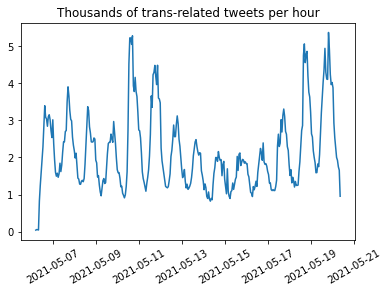

In [3]:
import matplotlib.pyplot as plt

tweets_per_hour = tweet_df.set_index('date')['tweet'].resample('1H').count() / 1000
plt.plot(tweets_per_hour)
plt.xticks(rotation=30)
plt.title('Thousands of trans-related tweets per hour')
plt.show()

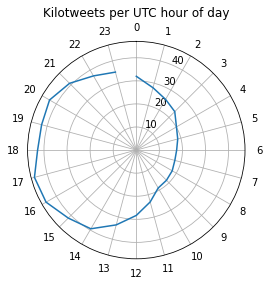

In [4]:
import numpy as np

thousands_sum_tweets_per_hour = tweet_df['date'].groupby(tweet_df['date'].dt.hour).count() / 1000
thousands_sum_tweets_per_hour.index /= 2 * np.pi
theta = np.linspace(0, 2*np.pi, 24, endpoint=False)

ax_hour = plt.subplot(111, projection='polar')
ax_hour.plot(theta, thousands_sum_tweets_per_hour)

ax_hour.set_xticks(theta)
ax_hour.set_theta_direction(-1)
ax_hour.set_xticklabels(range(24))
ax_hour.set_theta_zero_location("N")
ax_hour.set_title('Kilotweets per UTC hour of day')

plt.show()

The most tweets are written between 14:00-21:00 UTC, which corresponds to 9:00AM-4:00PM CST. This indicates a correlation between when Americans are active and activity on this subject. It could be because Americans have more to say on it, but it could also just be that Twitter in general gets more activity from Americans.

## Exploratory Data Analysis

What are the most common phrases in this document? First, we will tokenize the corpus and remove its stopwords.

In [5]:
import string
import nltk


nltk.download('stopwords')
nltk.download('wordnet')

# Build stopword set
def build_standard_stopword_set():
    stopwords = set()
    stopwords.update(nltk.corpus.stopwords.words('english'))
    stopwords.update(nltk.corpus.stopwords.words('spanish'))
    stopwords.update(string.punctuation)

    # Some twitter-specific ones
    stopwords.update(['rt', '…', '—', 'u'])
    return stopwords

standard_stopwords = build_standard_stopword_set()

[nltk_data] Downloading package stopwords to /home/astrid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/astrid/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
import nltk
from collections import defaultdict

TOKEN_PERMITTED_CHARS = set('#@')


def is_token(token: str, stopwords):
    return all((
        c.isalnum() or c in TOKEN_PERMITTED_CHARS
        for c in token
    )) and token not in stopwords


tokenizer = nltk.TweetTokenizer(strip_handles=True, reduce_len=True)
lemmatizer = nltk.WordNetLemmatizer()


def tokenize_tweet(tweet, stopwords=standard_stopwords):
    """Given a tweet and a set of stopwords, converts the tweet into tokens."""
    tokens = (tok.lower() for tok in tokenizer.tokenize(tweet))
    lemmatized = (
        lemmatizer.lemmatize(tok)
        for tok in tokens
    )
    filtered = (
        tok for tok in lemmatized
        if is_token(tok, stopwords)
    )

    return list(filtered)

Now, let's plot the most common n-grams in this corpus. Because 700,000 tweets is a very large number, we will only do it on 20,000 tweets.

In [11]:
def calculate_word_freqs(series, stop, ngram_size=1):
    ng_tokenizer = NgramTokenizer(ngram_size, stop)
    flat_ngrams = (
        ' '.join(ngram) 
        for doc in series
        for ngram in nltk.ngrams(tokenize_tweet(doc, stop), ngram_size)
    )
    
    ngrams = pd.Series(flat_ngrams)
            
    frequencies = ngrams.value_counts()
    frequencies.sort_values(inplace=True, ascending=False)
    return frequencies

def plot_frequencies(ax: plt.Axes, freq_series, top_count=30):
    top_n = freq_series.iloc[:top_count]
    index = [
        f'{i + 1}: {word}'
        for i, word in enumerate(top_n.index)
    ]
    ax.barh(index, top_n)
    ax.invert_yaxis()


def plot_ngrams(ax, tweet_series, stop, ngram_size=1, top_count=50):
    frequency = calculate_word_freqs(tweet_series, stop, ngram_size=ngram_size)
    plot_frequencies(ax, frequency, top_count=top_count)
    gram_label = f'{ngram_size}-gram' 
    ax.set_title(f'Top {top_count} {gram_label}s in corpus')
    ax.set_ylabel(f'{gram_label}')
    ax.set_xlabel(f'Number of occurences')

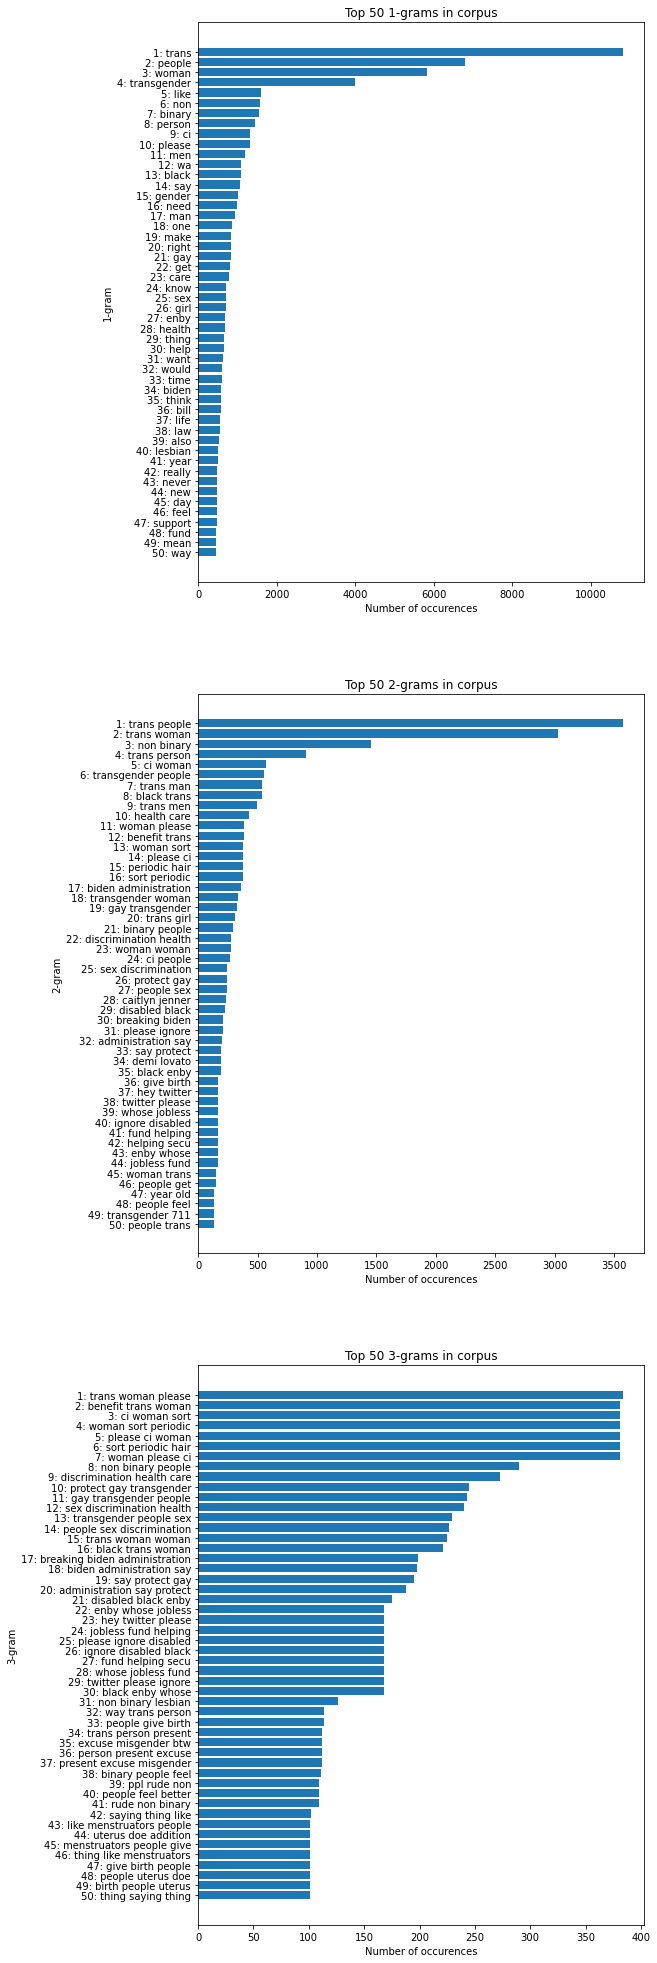

In [12]:
ngram_tweet_sample = tweet_df.sample(20_000, random_state=0)
_, axs = plt.subplots(3, 1, figsize=(8, 35))

for i, ax in enumerate(axs.flatten()):
    ngram_size = i + 1
    plot_ngrams(ax, ngram_tweet_sample['tweet'], standard_stopwords, ngram_size=ngram_size)
plt.show()

### Observations from n-gram analysis

Some interesting results have popped up already.

- In 1-grams, `trans`, `people`, and `transgender` unsurprisingly show up a lot of times. But interestingly, in the 2-grams, `trans woman` is twice as common as `non binary`, which itself is almost three times as common as `trans man`. Trans women seem to receive the most attention, as usual.
- `black trans`, `black enby`, and `disabled black` show up a lot, as well, indicating an emphasis on intersectionality.
- On May 10, the [Biden administration declared it would enforce transgender healtcare protections](https://www.cnn.com/2021/05/10/politics/hhs-transgender-healthcare-protections-biden-administration/index.html), which is why mentions of biden show up a lot.
- There is mention of Caitlyn Jenner (2-gram #26), who has recently announced her run for the California governorship. When this was run on older data (between 2021-04-20 and 2021-04-27) she popped up a lot more often.
- Demi Lovato (2-gram #40) came out as nonbinary a few days ago.

You'll notice that stopword filtering and lemmatization have produced some interesting artifacts:
- The 26th 3-gram `trans woman woman` shows up a lot. This is likely "trans women are women," but "are" got chopped off. 
- `ci` shows up a lot. This likely doesn't mean "continuous integration," but rather "cis" as in "cisgender" being mistakenly assumed as a plural or possessive by the lemmatizer.

#### The retweet problem

There are a few limitations that have popped up with raising the n-gram length, however. You may notice some very large blocks of similar counts and similar words in 3-grams, like 1-6 or 10-19. These are tweets that have been retweeted a lot of times. Although it is not included in this notebook, this phenomenon gets worse with 4-grams. See the following cells for the corresponding tweets.

In [13]:
def tweets_containing_ngram(ngram):
    n = len(ngram)
    mask = (
        ngram_tweet_sample['tweet']
            .map(lambda t: ngram in nltk.ngrams(tokenize_tweet(t), n))
    )
    return ngram_tweet_sample[mask]

[@retronouns](https://twitter.com/retronouns/status/1391924254543912960), 15.8k retweets:

> for the benefit of all the trans women out there, please RT this if you're a cis woman and do some sort of periodic hair removal on your face

In [14]:
tweets_containing_ngram(('trans', 'woman', 'please'))

,tweet,author,date,id
83439,RT @retronouns: for the benefit of all the tra...,chia_patel,2021-05-11 22:39:28,1392248017017659392
76987,RT @retronouns: for the benefit of all the tra...,semah_baset,2021-05-12 00:27:57,1392275315364335631
116884,RT @retronouns: for the benefit of all the tra...,Nose_TurntUp,2021-05-11 14:24:28,1392123443626139649
78826,RT @retronouns: for the benefit of all the tra...,LoveWillThaw_13,2021-05-11 23:55:55,1392267255828738049
79911,RT @retronouns: for the benefit of all the tra...,greatbrittani,2021-05-11 23:37:31,1392262624675602437
...,...,...,...,...
107638,RT @retronouns: for the benefit of all the tra...,gomer2323,2021-05-11 16:52:19,1392160653687726087
113681,RT @retronouns: for the benefit of all the tra...,lauracb88,2021-05-11 15:19:26,1392137277053222913
99254,RT @retronouns: for the benefit of all the tra...,Payton_Ems,2021-05-11 18:47:19,1392189593156456449
89240,RT @retronouns: for the benefit of all the tra...,MysteryCorgi,2021-05-11 21:13:02,1392226263524429825


This tweet appears to no longer exist on Twitter, but here is a related tweet from the same person.

[@enbymilesmiles](https://twitter.com/enbymilesmiles/status/1390773557072863233), 362 retweets: 
> URGENT PLEASE READ
> 
> I’ve been jobless and these funds have been helping me secure my survival since. I’m raising funds for rent assistance and for top surgery. Please at least retweet if you see this. Thank you to all who help and have helped. My life is to you.

In [15]:
tweets_containing_ngram(('enby', 'whose', 'jobless'))

,tweet,author,date,id
119853,RT @enbymilesmiles: hey Twitter please don't i...,kai_o_0,2021-05-11 13:31:02,1392109997685886979
69831,RT @enbymilesmiles: hey Twitter please don't i...,bangtansoobin,2021-05-12 03:40:52,1392323864659513347
45319,RT @enbymilesmiles: hey Twitter please don't i...,PlannetteD,2021-05-12 17:25:54,1392531492719390720
101129,RT @enbymilesmiles: hey Twitter please don't i...,JMan4002,2021-05-11 18:23:04,1392183490834227213
67330,RT @enbymilesmiles: hey Twitter please don't i...,moonlightlexie,2021-05-12 05:13:19,1392347131688718336
...,...,...,...,...
50060,RT @enbymilesmiles: hey Twitter please don't i...,fibromiteready1,2021-05-12 15:35:38,1392503743866884096
73949,RT @enbymilesmiles: hey Twitter please don't i...,NoleDotJpg,2021-05-12 01:30:14,1392290991973965826
68097,RT @enbymilesmiles: hey Twitter please don't i...,TVdinners1111,2021-05-12 04:41:56,1392339232761384961
71606,RT @enbymilesmiles: hey Twitter please don't i...,ulteunbixx,2021-05-12 02:37:51,1392308006814060547


To deal with this, we *could* remove every retweet from the dataset. However, in doing so, it might become less representative of the weight of different topics in the dataset as a whole. So, we will simply leave them in.

## Topic Modeling

Now, we will do some unsupervised learning and classification to see if we can pry apart different topics from this dataset. First, we will train a TF-IDF vectorizer on our dataset.

In [16]:
import sklearn

@autopickle('../models/final-tfidf.pickle.gz')
def vectorizer():
    vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
        tokenizer=tokenize_tweet
    )
    vectorizer.fit(tweet_df['tweet'])
    return vectorizer

Next, we will split our tweets into a few different datasets.

In [17]:
N_HYPER_TUNING = 50_000
N_TEST = 100_000

shuffled = tweet_df.sample(frac=1, random_state=0)
df_hyper_tuning = shuffled.iloc[:N_HYPER_TUNING]
df_training = shuffled.iloc[N_HYPER_TUNING:-N_TEST]
df_test = shuffled.iloc[:-N_TEST]
del shuffled  # save memory

print(f'Hyperparameter Tuning: {len(df_hyper_tuning)}')
print(f'Training: {len(df_training)}')
print(f'Test: {len(df_test)}')

Hyperparameter Tuning: 50000
Training: 586415
Test: 636415


Let's run a LDA on a small sample of the training data first to see what it looks like.

In [18]:
from sklearn.decomposition import LatentDirichletAllocation

@autopickle('../models/final-sample-lda.pickle.gz')
def sample_lda():
    lda = LatentDirichletAllocation(
        n_components=40,
        max_iter=15,
        n_jobs=-1,  # all processors
    )
    lda.fit(vectorizer.transform(df_training['tweet'].sample(50_000, random_state=0)))
    return lda

In [25]:
X = vectorizer.transform(df_training['tweet'].sample(50_000, random_state=0))
print(f'Perplexity: {sample_lda.perplexity(X)}')
print(f'Log-likelihood: {sample_lda.score(X)}')

/home/astrid/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Perplexity: 46707.38769820572
Log-likelihood: -1617297.7709882844


In [26]:
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(sample_lda, vectorizer.transform(df_test['tweet']), vectorizer, mds='pca')

/home/astrid/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
30    -0.382935  0.014511       1        1  21.027693
31    -0.054228 -0.184914       2        1   3.470150
7     -0.101517 -0.021352       3        1   3.401969
28    -0.025540  0.144660       4        1   2.975686
0     -0.067795 -0.013044       5        1   2.804393
22    -0.054727 -0.041708       6        1   2.780011
27     0.018787 -0.036729       7        1   2.565587
1      0.021948  0.069940       8        1   2.561676
8     -0.017235  0.017171       9        1   2.538406
10    -0.049767  0.016584      10        1   2.345535
39    -0.001242  0.057709      11        1   2.309338
26    -0.028206  0.058283      12        1   2.271801
33     0.000639 -0.000894      13        1   2.250495
13    -0.007793  0.015418      14        1   2.249538
25    -0.005962 -0.007713      15        1   2.206905
17    -0.005546 -0.019228      16        1   2.174655
14     0.003142 -0.009784      17        1   2.161808
5     -0.008629  0.047523      18        1   2.129503
18     0.012703  0.019876      19        1   2.120655
20     0.004363  0.006659      20        1   2.093351
38     0.009132 -0.086223      21        1   2.073396
34     0.014692 -0.002744      22        1   2.013018
4     -0.005958  0.025325      23        1   2.010986
23    -0.005824 -0.015241      24        1   1.896487
12     0.006040  0.001397      25        1   1.816125
24     0.035483 -0.011955      26        1   1.750989
29     0.024097  0.030370      27        1   1.734912
37     0.027955 -0.022079      28        1   1.721732
2      0.038960 -0.006646      29        1   1.704564
16     0.033723 -0.022154      30        1   1.607684
21     0.042758  0.007016      31        1   1.601494
6      0.045547 -0.006372      32        1   1.507064
19     0.031067  0.010307      33        1   1.406931
35     0.046829  0.009523      34        1   1.368202
32     0.052000 -0.018624      35        1   1.299737
15     0.059224 -0.011090      36        1   1.287464
11     0.064477 -0.010292      37        1   1.223441
9      0.079573 -0.004382      38        1   1.211117
3      0.075546  0.000447      39        1   1.178641
36     0.074221  0.000449      40        1   1.146857, topic_info=               Term          Freq         Total Category  logprob  loglift
115445        woman  15048.000000  15048.000000  Default  30.0000  30.0000
53588          hair   2707.000000   2707.000000  Default  29.0000  29.0000
99287          sort   2669.000000   2669.000000  Default  28.0000  28.0000
23814       benefit   2630.000000   2630.000000  Default  27.0000  27.0000
82869      periodic   2613.000000   2613.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
106906  transgender     42.069720  10138.167820  Topic40  -6.2577  -1.0166
106656        trans     36.924900  18770.625523  Topic40  -6.3882  -1.7630
82637        people     34.889287  15191.879747  Topic40  -6.4449  -1.6082
36340        deeply     24.171185    141.396067  Topic40  -6.8119   2.7017
36001         death     24.418423    232.869410  Topic40  -6.8017   2.2130

[2374 rows x 6 columns], token_table=        Topic      Freq                                  Term
term                                                         
617        12  0.823703                             #applesmp
925        12  0.850032                         #bathroombill
1216       25  0.901127                             #bisexual
1482        8  0.101636                             #breaking
1482       17  0.843580                             #breaking
...       ...       ...                                   ...
122099     30  0.822489          この作品はまさに政治的に正しくないので低評価になっている
122158     30  0.822489  これらのキャラクターの名前にlgbtを冷笑的に扱うニュアンスがあったから
122438     30  0.822489                             ちょっと面白いのは
123333     30  0.822489                ニューウォーリアーズの予告動画が低評価なのは
125424 

During our n-gram analysis, we found out that bigrams and trigrams can reveal more information than unigrams sometimes. So, we can try running LDA on bigrams and trigrams.

In [20]:
@autopickle('../models/final-tfidf2.pickle.gz')
def vectorizer2():
    vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
        tokenizer=tokenize_tweet,
        ngram_range=(2, 2)
    )
    vectorizer.fit(tweet_df['tweet'])
    return vectorizer

/home/astrid/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
@autopickle('../models/final-sample-lda-bigram.pickle.gz')
def sample_lda2():
    lda = LatentDirichletAllocation(
        n_components=40,
        max_iter=15,
        n_jobs=-1,  # all processors
    )
    lda.fit(vectorizer2.transform(df_training['tweet'].sample(50_000, random_state=0)))
    return lda

pyLDAvis.sklearn.prepare(sample_lda, vectorizer2.transform(df_test['tweet']), vectorizer2, mds='tsne')

/home/astrid/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AssertionError: Topic-term distributions and document-term matrixhave different number of columns, 126850 != 1429662.

While this is decent, it could be better. 

### Hyperparameter Tuning

We will use grid search to look for better parameter combinations.
**This will take a long time.**

In [ ]:
import tmtoolkit

def get_sklearn_coherence(model):
    metric_coherence_gensim(
        measure='c_v', 
        top_n=25, 
        topic_word_distrib=lda_model.components_, 
        dtm=dtm_tf, 
        vocab=np.array([x for x in vect.vocabulary_.keys()]), 
        texts=train['cleaned_NOUN'].values)


@autopickle('../models/final-gridsearch-lda.pickle.gz')
def grid_search_lda():
    gs = sklearn.model_selection.GridSearchCV(
        estimator=sklearn.decomposition.LatentDirichletAllocation(
            random_state=0,
            n_jobs=-1,
        ),
        param_grid={
            'n_components': [20, 25, 30, 35, 40, 45],
            'learning_decay': [.6, .7, .8, .9]
        },
        verbose=2,
    )
    vectorized_train = vectorizer.transform(df_hyper_tuning['tweet'])
    gs.fit(vectorized_train)
    return gs

grid_search_lda.best_params_

Now we can train on our main training dataset using these parameters.

In [ ]:
@autopickle('../models/final-hpt-lda.pickle.gz')
def hp_tuned_lda():
    lda = sklearn.decomposition.LatentDirichletAllocation(
        **grid_search_lda.best_params_,
        random_state=0,
        n_jobs=-1,
    )
    lda.fit(vectorizer.transform(df_training['tweet']))
    return lda

In [ ]:
pyLDAvis.sklearn.prepare(hp_tuned_lda, vectorizer.transform(df_training['tweet']), vectorizer, mds='tsne')

## Conclusion

reflection

next steps



## Addendum: Insights from a Previous Dataset

This following dataset was collected from tweets containing either `trans people` or `transgender` between the dates of 2021-04-20 and 2021-04-27, about 2 weeks before the dataset from above. A very large number of events happened this week, and it provides different, but just as interesting insights. 

This was not concatenated to the primary dataset for two main reasons.

1. It has different search terms. Non-binary topics are likely to be de-emphasized here.
2. It is not contiguous with the later dataset. There will be a 2-week hole of data, which will likely reduce the quality of results.

Nevertheless, the results are displayed here for your viewing pleasure.

In [ ]:
@autopickle('../data/old-tweet-data.pickle.gz')
def old_tweet_df():
    PATHS = [
        '../data/search_transgender.jsonl.gz',
        '../data/search_trans_people.jsonl.gz',
    ]

    df = pd.concat([read_jsonl_gz(path) for path in PATHS])
    df.drop_duplicates('id', inplace=True)
    return df

old_tweet_df

### N-gram Frequency Analysis

In [ ]:
ngram_tweet_sample = old_tweet_df.sample(50_000, random_state=0)
_, axs = plt.subplots(4, 1, figsize=(8, 45))

for i, ax in enumerate(axs.flatten()):
    ngram_size = i + 1
    plot_ngrams(ax, ngram_tweet_sample['tweet'], standard_stopwords, ngram_size=ngram_size)
plt.show()

- There is mention of the Myanmar coup, which attacked and abducted Mingalar Taungnyunt, a trans woman involved in the protests.
- Just as before, `trans woman` is near the top of the 2-grams, while `trans man` is nowhere to be seen. Non-binary people are not mentioned, however, 
- A mass shooting on Thursday was performed by a trans man.
- Caitlyn Jenner (2-gram #3) announced her run for governor. 
- There are mentions of the LGB alliance, a TERF (trans-exclusionary radical feminist) group.
- `go fund goal` is likely the result of `go fund me goal` after stopword removal. 
- There is mention of various bills where republicans attack trans people in women's sports, such as `florida genital inspection` or  `texas senate approved sb1646`.
- There seems to be a tweet with a large number of retweets, which listed bills in Georgia that got signed by the Governor. One of them was an anti-trans bill, the other was a running-over-protestors bill, and another made it illegal to film police. Thus, they all got lumped together.